# Amazon Fine Food Reviews KNN Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review

In [1]:
!ls

LSTMCompatible.pkl  sample_data


In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import hashlib
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import backend as K
import matplotlib.pyplot as plt
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
conn = sqlite3.connect('final.sqlite')

In [0]:
data = pd.read_sql_query("""
SELECT *
FROM Reviews""", conn)
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364171 entries, 0 to 364170
Data columns (total 12 columns):
index                     364171 non-null int64
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null object
Time                      364171 non-null int64
Summary                   364171 non-null object
Text                      364171 non-null object
CleanedText               364171 non-null object
dtypes: int64(5), object(7)
memory usage: 33.3+ MB


## Preprocessing Cleaned Text to generate LSTM Input:

In [0]:
sentences = np.array(data['CleanedText'])
i = 0
for sent in sentences:
    sentences[i] = sent.decode('utf-8')
    i += 1
print(sentences[0])
print(sentences.shape)

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
(364171,)


In [0]:
# Find all words in the cleanedtext
vocab = set()
for x in sentences:
    for word in x.split():
        vocab.add(word)
        
len(vocab)

71626

In [0]:
# Create a dictionary from vocabulary.
vocab_dict = dict.fromkeys(vocab, 0)


In [0]:
# Calculate count of each word..
for x in sentences:
    for word in x.split():
        vocab_dict[word]+=1

In [0]:
k = []
v = []
for keys,val in vocab_dict.items():
    k.append(keys)
    v.append(val)

In [0]:
kv = np.vstack((k,v)).T

In [0]:
kv.shape

(71626, 2)

In [0]:
df = pd.DataFrame(columns=["Word","Count"], data=kv)
df['Count'] = df['Count'].astype('int')
df.head()

,Word,Count
0,choic,7228
1,definet,249
2,peantu,1
3,silliest,2
4,mankind,30


In [0]:
# Sort the dataframe to get the largest count at first place
df.sort_values(by=['Count'], ascending=False, inplace=True)
df.head()

,Word,Count
19145,like,171759
66825,tast,163632
40395,flavor,129199
25943,good,127807
60564,product,119251


In [0]:
# Give numbering to the most frequent word as 1 then next as 2 and so on.
df.reset_index(inplace=True)
df['mapping'] = df.index + 1
df.head()

,index,Word,Count,mapping
0,19145,like,171759,1
1,66825,tast,163632,2
2,40395,flavor,129199,3
3,25943,good,127807,4
4,60564,product,119251,5


In [0]:
df.drop(columns=['index'], inplace=True)
df.head()

,Word,Count,mapping
0,like,171759,1
1,tast,163632,2
2,flavor,129199,3
3,good,127807,4
4,product,119251,5


In [0]:
df.drop(columns=['Count'], inplace=True)
df.head()

,Word,mapping
0,like,1
1,tast,2
2,flavor,3
3,good,4
4,product,5


In [0]:
# Convert to dictionary for easier processing.
dictionary = dict(zip(df['Word'], df['mapping']))
len(dictionary)

71626

In [0]:
# Remove no longer need variables to free up space.
del(df)
del(sentences)
del(k)
del(v)
del(kv)

In [0]:
# Function takes a string as input returns a list of numbers mapping word to a number in dictionary
def change(x):
    x = x.decode("utf-8")
    l = list()
    for words in x.split():
        l.append(dictionary[words])
        
    return l

In [0]:
new_df = data
new_df.shape

(364171, 13)

In [0]:
# Get LSTM Feature....
new_df['lstm_feature'] = new_df['CleanedText'].apply(change)
new_df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,lstm_feature
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,"[14823, 28, 1082, 14, 369, 2407, 3185, 13533, ..."
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...,"[1035, 232, 12533, 1082, 661, 19, 8077, 1215, ..."
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...,"[694, 61, 826, 793, 130, 44, 793, 9583, 1414, ..."
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...,"[9, 28, 1082, 232, 69, 8996, 34, 4, 8120, 28, ..."
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...,"[1082, 11507, 130, 44, 431, 130, 1419, 28, 958..."


In [0]:
new_df = new_df[['lstm_feature', 'Score']]
new_df.head()

,lstm_feature,Score
0,"[14823, 28, 1082, 14, 369, 2407, 3185, 13533, ...",positive
1,"[1035, 232, 12533, 1082, 661, 19, 8077, 1215, ...",positive
2,"[694, 61, 826, 793, 130, 44, 793, 9583, 1414, ...",positive
3,"[9, 28, 1082, 232, 69, 8996, 34, 4, 8120, 28, ...",positive
4,"[1082, 11507, 130, 44, 431, 130, 1419, 28, 958...",positive


In [0]:
new_df.shape

(364171, 2)

In [0]:
new_df['Score'] = new_df.Score.replace(to_replace=['positive', 'negative'], value=[1,0])
new_df.head()

C:\Users\Prakhar\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,lstm_feature,Score
0,"[14823, 28, 1082, 14, 369, 2407, 3185, 13533, ...",1
1,"[1035, 232, 12533, 1082, 661, 19, 8077, 1215, ...",1
2,"[694, 61, 826, 793, 130, 44, 793, 9583, 1414, ...",1
3,"[9, 28, 1082, 232, 69, 8996, 34, 4, 8120, 28, ...",1
4,"[1082, 11507, 130, 44, 431, 130, 1419, 28, 958...",1


In [0]:
new_df['Score'].unique()

array([1, 0], dtype=int64)

In [0]:
# Saving the generated datafrem to file..
new_df.to_pickle("LSTMCompatible.pkl")

## Training an LSTM Model :

In [3]:
data = pd.read_pickle("LSTMCompatible.pkl")
data.head()

,lstm_feature,Score
0,"[14823, 28, 1082, 14, 369, 2407, 3185, 13533, ...",1
1,"[1035, 232, 12533, 1082, 661, 19, 8077, 1215, ...",1
2,"[694, 61, 826, 793, 130, 44, 793, 9583, 1414, ...",1
3,"[9, 28, 1082, 232, 69, 8996, 34, 4, 8120, 28, ...",1
4,"[1082, 11507, 130, 44, 431, 130, 1419, 28, 958...",1


In [4]:
X_train = data[:int(0.7 * data.shape[0])]
X_train.shape

(254919, 2)

In [5]:
X_test = data[int(0.7 * data.shape[0]):]
X_test.shape

(109252, 2)

In [6]:
y_train = X_train['Score']
y_test = X_test['Score']
X_train.drop(columns=['Score'], inplace=True)
X_test.drop(columns=['Score'], inplace=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(254919, 1)
(109252, 1)
(254919,)
(109252,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
# Find maximum length vector in LSTM Feature
m = 0
for x in data['lstm_feature']:
    m = max(m, len(x))
print(m)

1355


In [0]:
# Extract the data
X_train = np.array(X_train['lstm_feature'])
X_test = np.array(X_test['lstm_feature'])

In [0]:
max_review_length = 1500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [10]:
X_train.shape

(254919, 1500)

In [11]:
X_test.shape

(109252, 1500)

In [0]:
# create the model
embedding_vecor_length = 32
total_words = 71626
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=1500))
model.add(CuDNNLSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1500, 32)          2292032   
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 100)               53600     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,345,733
Trainable params: 2,345,733
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = model.fit(X_train, y_train, nb_epoch=10, batch_size=1024, validation_split=0.2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 203935 samples, validate on 50984 samples
Epoch 1/10
203935/203935 [==============================] - 180s 884us/step - loss: 0.2949 - acc: 0.8868 - val_loss: 0.2233 - val_acc: 0.9121
Epoch 2/10
203935/203935 [==============================] - 181s 889us/step - loss: 0.2085 - acc: 0.9197 - val_loss: 0.2217 - val_acc: 0.9102
Epoch 3/10
203935/203935 [==============================] - 181s 890us/step - loss: 0.1825 - acc: 0.9299 - val_loss: 0.2133 - val_acc: 0.9165
Epoch 4/10
203935/203935 [==============================] - 182s 890us/step - loss: 0.1736 - acc: 0.9331 - val_loss: 0.2241 - val_acc: 0.9156
Epoch 5/10
203935/203935 [==============================] - 182s 892us/step - loss: 0.1683 - acc: 0.9350 - val_loss: 0.2083 - val_acc: 0.9168
Epoch 6/10
203935/203935 [==============================] - 182s 892us/step - loss: 0.2042 - acc: 0.9192 - val_loss: 0.2467 - val_acc: 0.9010
Epoch 7/10
203935/203935 [==============================] - 182s 893us/step - loss: 0.1623 - acc:

Text(0.5, 1.0, 'Accuracy Curves')

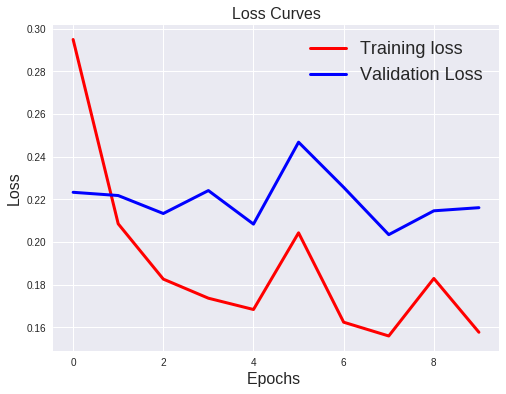

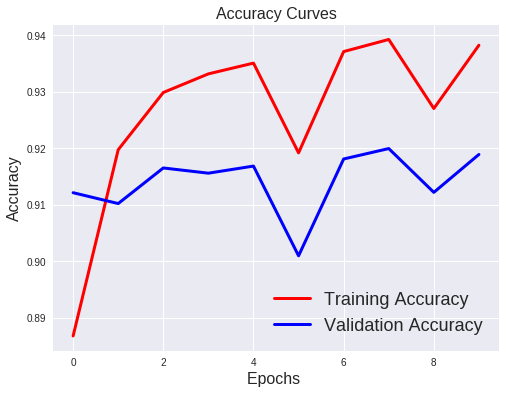

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [12]:
# create the model
embedding_vecor_length = 32
total_words = 71626
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=1500))
model.add(CuDNNLSTM(100, return_sequences=True))
model.add(CuDNNLSTM(150))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 32)          2292032   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 1500, 100)         53600     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 150)               151200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 2,496,983
Trainable params: 2,496,983
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
history = model.fit(X_train, y_train, nb_epoch=10, batch_size=768, validation_split=0.4)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 152951 samples, validate on 101968 samples
Epoch 1/10
152951/152951 [==============================] - 425s 3ms/step - loss: 0.2776 - acc: 0.8924 - val_loss: 0.2294 - val_acc: 0.9069
Epoch 2/10
152951/152951 [==============================] - 426s 3ms/step - loss: 0.2092 - acc: 0.9212 - val_loss: 0.2805 - val_acc: 0.8758
Epoch 3/10
152951/152951 [==============================] - 424s 3ms/step - loss: 0.1831 - acc: 0.9290 - val_loss: 0.2160 - val_acc: 0.9193
Epoch 4/10
152951/152951 [==============================] - 426s 3ms/step - loss: 0.1732 - acc: 0.9330 - val_loss: 0.2006 - val_acc: 0.9196
Epoch 5/10
152951/152951 [==============================] - 430s 3ms/step - loss: 0.1670 - acc: 0.9355 - val_loss: 0.2020 - val_acc: 0.9203
Epoch 6/10
152951/152951 [==============================] - 432s 3ms/step - loss: 0.1616 - acc: 0.9378 - val_loss: 0.2258 - val_acc: 0.9111
Epoch 7/10
152951/152951 [==============================] - 427s 3ms/step - loss: 0.2096 - acc: 0.9171 - val

Text(0.5, 1.0, 'Accuracy Curves')

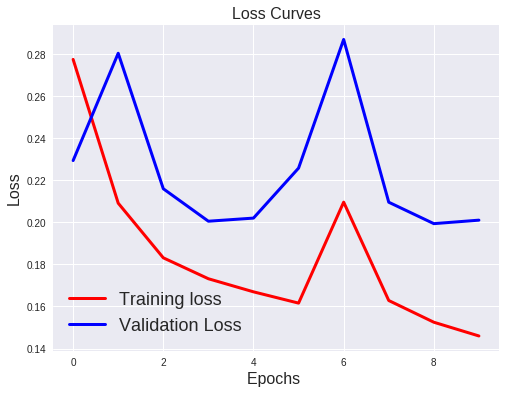

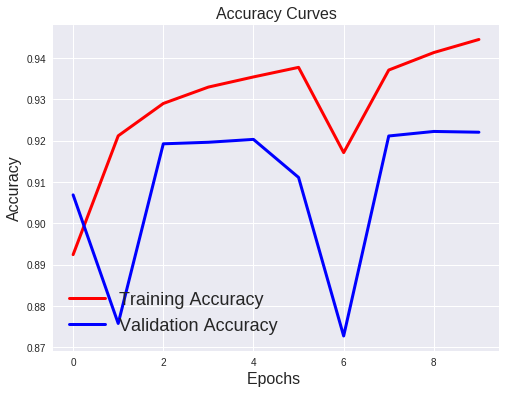

In [14]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Results :

<table>
    <tr><th>Architecture</th><th>Train Accuracy</th><th>Test Accuracy</th><th>CV Accuracy</th></tr>
    <tr><td>1 LSTM Cell</td><td>93.82</td><td>92.11</td><td>91.89</td></tr>
    <tr><td>2 LSTM Cells</td><td>94.45</td><td>91.93</td><td>92.21</td></tr>
</table>